# Excercise 2

## Load the data

In [1]:
def load_data(pickle_file):
    import pickle

    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

## Plot the images

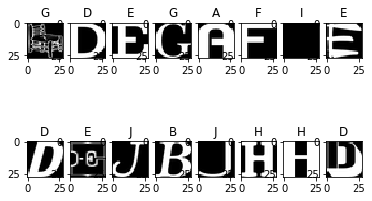

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def label_to_char(one_hot):
    return "ABCDEFGHIJ"[one_hot]

n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))
    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(label_to_char(train_labels[image_to_show]))


## Helper Functions

In [14]:
image_size = 28
num_labels = 10

# Convert 2 to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  labels = to_one_hot(labels)
  return dataset, labels

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))

## Simple classification pipeline

In [4]:
import numpy as np

def accuracy(predictions, labels):
    return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))
  



## Our first classifier


In [5]:
class RandomClassifier:
    import random
    
    def fit(self, train_dataset, train_labels):
        pass
    
    def predict(self, data):
        return [random.randint(0,9) for i in data]

In [6]:
evaluate_classifier(RandomClassifier())

Test accuracy: 0.096


## Hands-On: Logistic Regression

Now it's time to create your first real classifier. We are going to train the linear model you saw previously. 

**Hints**:

You can use the following functions:

    tf.matmul
    tf.nn.softmax
    tf.nn.softmax_cross_entropy_with_logits


In [15]:
import tensorflow as tf

class TensorLogisticRegression:
    def __init__(self):
        self.num_steps = 1000
       
    def fit(self, train_dataset, train_labels):
        train_dataset, train_labels = reformat(train_dataset, train_labels)
        
        graph = tf.Graph()
        with graph.as_default():
          # Load the Data
          tf_train_dataset = tf.constant(train_dataset)
          tf_train_labels = tf.constant(train_labels)

          # Linear Model
          weights = tf.Variable(tf.zeros([image_size * image_size, num_labels]))
          biases = tf.Variable(tf.zeros([num_labels]))

          logits = tf.matmul(tf_train_dataset, weights) + biases
          prediction = tf.nn.softmax(logits) 
            
          loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

          # Optimizer.
          optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
          
        
        with tf.Session(graph=graph) as session:
          print_row(['Step', 'Loss', 'A-Train'])
          tf.global_variables_initializer().run()
          for step in range(self.num_steps):
            w, b, _, l, predictions = session.run([weights, biases, optimizer, loss, prediction])
            if (step % 100 == 0):
              train_acc = accuracy(from_one_hot(predictions), from_one_hot(train_labels))                  

              print_row([step, l, train_acc])
                
          self.weights = w
          self.biases = b
            
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        graph = tf.Graph()
        with graph.as_default():
            weights = tf.constant(self.weights)
            biases = tf.constant(self.biases)
            tfdata = tf.constant(data)
            logits = tf.matmul(data, weights) + biases
            
            prediction = tf.nn.softmax(logits)
            
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            predictions, _ = session.run([prediction, logits])
            return from_one_hot(predictions)


In [16]:
evaluate_classifier(TensorLogisticRegression())

Step                Loss                A-Train             
0                   2.3026              0.105               
100                 0.616355            0.8352              
200                 0.578762            0.8444              
300                 0.556688            0.8505              
400                 0.540708            0.8555              
500                 0.528034            0.859               
600                 0.517452            0.8617              
700                 0.508325            0.8644              
800                 0.500275            0.8669              
900                 0.493057            0.8688              
Test accuracy: 0.878
